In [1]:
import pandas as pd
import numpy as np
import calendar
from timeit import default_timer as timer
import datetime as dt
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning

In [2]:
data=pd.read_excel('card transactions.xlsx')

In [3]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


In [5]:
# remove one incorrect record
data.drop([52714], axis=0, inplace=True)

In [6]:
# remove transaction types not equal 'P'
data = data[data['Transtype']=='P']

### Fill missing fields

In [7]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3198
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [8]:
# Merch num:
# groupby description and use the mode
# if no description avaliable, leave it na
data['Merchnum'] = data['Merchnum'].fillna(data.groupby(['Merch description'])['Merchnum'] \
                        .transform(lambda x:x.mode()[0] if x.mode().empty==False else np.NaN))

In [9]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             2038
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [10]:
# Merch zip:
# group by description and use the mode
# if no mode available, leave it na
data['Merch zip'] = data['Merch zip'].fillna(data.groupby(['Merch description'])['Merch zip'] \
                        .transform(lambda x:x.mode()[0] if x.mode().empty==False else np.NaN))

In [11]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             2038
Merch description       0
Merch state          1020
Merch zip            2043
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [12]:
# Merch state:
# first group by description and use the mode
# if no mode available, leave it na
data['Merch state'] = data['Merch state'].fillna(data.groupby(['Merch description'])['Merch state'] \
                        .transform(lambda x:x.mode()[0] if x.mode().empty==False else np.NaN))

In [13]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             2038
Merch description       0
Merch state           363
Merch zip            2043
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [14]:
# for remaining missing state, use known zip-state pair to fill

In [15]:
# find all rows where zip is not NaN for missing state
d = data[(data['Merch state'].isnull()==True) & (data['Merch zip'].isnull()==False)]
d

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
3258,3259,5142153880,2010-01-14,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2340.00,0
3262,3263,5142154098,2010-01-14,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2387.00,0
3540,3541,5142154098,2010-01-17,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2300.00,0
3642,3643,5142153880,2010-01-17,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2500.00,0
4969,4970,5142194136,2010-01-24,597597721468,CRISTALIA ACQUISITION COR,NaN,929.0,P,83.00,0
...,...,...,...,...,...,...,...,...,...,...
83272,83273,5142193384,2010-10-26,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,300.00,0
83425,83426,5142193384,2010-10-27,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,600.00,0
83454,83455,5142193384,2010-10-27,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,600.00,0
86405,86406,5142194136,2010-11-10,7007631331,AAFES BUCHANAN MAIN STR,NaN,934.0,P,184.41,0


In [16]:
# find matching state for zip
z_to_s = {}
for z in d['Merch zip'].unique():
    dz = data.loc[data['Merch zip']==z,'Merch state']
    if dz.mode().empty == True:
        s = np.NaN
    else:
        s = dz.mode()[0]
    z_to_s.update({z:s})
z_to_s

{926.0: nan,
 929.0: nan,
 1400.0: nan,
 65132.0: nan,
 86899.0: nan,
 23080.0: nan,
 60528.0: nan,
 6.0: 'IL',
 934.0: nan,
 738.0: nan,
 2.0: 'MD',
 90805.0: nan,
 76302.0: nan,
 9.0: 'CA',
 914.0: nan,
 95461.0: nan,
 50823.0: nan,
 48700.0: nan,
 680.0: nan,
 1.0: 'PA',
 681.0: nan,
 623.0: nan,
 726.0: nan,
 936.0: nan,
 12108.0: nan,
 791.0: nan,
 907.0: nan,
 922.0: nan,
 920.0: nan,
 3.0: 'GA',
 801.0: nan,
 8.0: 'CO',
 31040.0: nan,
 38117.0: 'TN',
 41160.0: nan}

In [17]:
for index in d.index:
    data.loc[index,'Merch state'] = z_to_s[data.loc[index,'Merch zip']]

In [18]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             2038
Merch description       0
Merch state           335
Merch zip            2043
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [19]:
# fill all missing fields to 'unknown'
data.fillna('unknown', inplace=True)

In [20]:
data.isna().sum()

Recnum               0
Cardnum              0
Date                 0
Merchnum             0
Merch description    0
Merch state          0
Merch zip            0
Transtype            0
Amount               0
Fraud                0
dtype: int64

## Feature Engineering

### Entity Variables

In [21]:
# create entities
data['Cardnum']=data['Cardnum'].astype(str)
data['Merchnum']=data['Merchnum'].astype(str)
data['Merch zip']=data['Merch zip'].astype(str)
data['card_merchnum']=data.Cardnum+data.Merchnum
data['card_zip']=data.Cardnum+data['Merch zip']
data['card_state']=data.Cardnum+data['Merch state']

In [22]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,card_merchnum,card_zip,card_state
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,51421904395509006296254,514219043938118.0,5142190439TN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,514218397361003026333,51421839731803.0,5142183973MA
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,51421317214503082993600,514213172120706.0,5142131721MD
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,51421484525509006296254,514214845238118.0,5142148452TN
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,51421904395509006296254,514219043938118.0,5142190439TN


In [23]:
attributes=['Cardnum','Merchnum','card_merchnum','card_zip','card_state']

### Candidate Variables

In [24]:
df1 = data.copy()
final = data.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum

In [25]:
start = timer()
for entity in attributes:
    st = timer()
    df_1 = df1[['Recnum','Date',entity]]
    df_r = df1[['check_record','check_date',entity,'Amount']]
    temp = pd.merge(df_1,df_r,left_on=entity,right_on=entity)
    #day since
    day_since_df = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
        .groupby('Recnum')[['Date','check_date']].last()
    mapper = (day_since_df.Date - day_since_df.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna(365,inplace=True)
    print(f'\n{entity}_day_since ---> Done')
    
    for offset_t in [0,1,3,7,14,30]:
        #frequency variable
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('Recnum')[entity].count()
        final[col_name] = final.Recnum.map(mapper2)
        #amount mean variable
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'ave_amount_{entity}_count_{offset_t}'
        mapper3 = count_day_df.groupby(entity)['Amount'].mean()
        final[col_name] = final[entity].map(mapper3)
        #amount max variable
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'max_amount_{entity}_count_{offset_t}'
        mapper4 = count_day_df.groupby(entity)['Amount'].max()
        final[col_name] = final[entity].map(mapper4)
        #amount sum variable
        
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'sum_amount_{entity}_count_{offset_t}'
        mapper5 = count_day_df.groupby(entity)['Amount'].sum()
        final[col_name] = final[entity].map(mapper5)
        #amount median variable
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'median_amount_{entity}_count_{offset_t}'
        mapper6 = count_day_df.groupby(entity)['Amount'].median()
        final[col_name] = final[entity].map(mapper6)
 


        print(f'{entity}_count_{str(offset_t)} ---> Done')
    print(f'Run time for entity {entity} ----------------{timer() - st:0.2f}s')
print(f'Total run time: {(timer()-start)/60:0.2f}min')


Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum_count_1 ---> Done
Cardnum_count_3 ---> Done
Cardnum_count_7 ---> Done
Cardnum_count_14 ---> Done
Cardnum_count_30 ---> Done
Run time for entity Cardnum ----------------21.22s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum_count_1 ---> Done
Merchnum_count_3 ---> Done
Merchnum_count_7 ---> Done
Merchnum_count_14 ---> Done
Merchnum_count_30 ---> Done
Run time for entity Merchnum ----------------137.70s

card_merchnum_day_since ---> Done
card_merchnum_count_0 ---> Done
card_merchnum_count_1 ---> Done
card_merchnum_count_3 ---> Done
card_merchnum_count_7 ---> Done
card_merchnum_count_14 ---> Done
card_merchnum_count_30 ---> Done
Run time for entity card_merchnum ----------------9.12s

card_zip_day_since ---> Done
card_zip_count_0 ---> Done
card_zip_count_1 ---> Done
card_zip_count_3 ---> Done
card_zip_count_7 ---> Done
card_zip_count_14 ---> Done
card_zip_count_30 ---> Done
Run time for entity card_zip -------

In [26]:
start = timer()
for entity in attributes:
    for offset_t in [0,1,3,7,14,30]:
        # amount act/mean variable
        col_name = f'act/mean_amount_{entity}_count_{offset_t}'
        final[col_name] = final['Amount']/final[f'sum_amount_{entity}_count_{offset_t}']
        # amount act/max variable
        col_name = f'act/max_amount_{entity}_count_{offset_t}'
        final[col_name] = final['Amount']/final[f'max_amount_{entity}_count_{offset_t}']
        # amount act/total variable
        col_name = f'act/sum_amount_{entity}_count_{offset_t}'
        final[col_name] = final['Amount']/final[f'sum_amount_{entity}_count_{offset_t}']
        # amount act/median variable
        col_name = f'act/median_amount_{entity}_count_{offset_t}'
        final[col_name] = final['Amount']/final[f'median_amount_{entity}_count_{offset_t}']
        print(f'{entity}_count_{str(offset_t)} ---> Done')
    print(f'Run time for entity {entity} ----------------{timer() - st:0.2f}s')
print(f'Total run time: {(timer()-start)/60:0.2f}min')

Cardnum_count_0 ---> Done
Cardnum_count_1 ---> Done
Cardnum_count_3 ---> Done
Cardnum_count_7 ---> Done
Cardnum_count_14 ---> Done
Cardnum_count_30 ---> Done
Run time for entity Cardnum ----------------10.40s
Merchnum_count_0 ---> Done
Merchnum_count_1 ---> Done
Merchnum_count_3 ---> Done
Merchnum_count_7 ---> Done
Merchnum_count_14 ---> Done
Merchnum_count_30 ---> Done
Run time for entity Merchnum ----------------10.57s
card_merchnum_count_0 ---> Done
card_merchnum_count_1 ---> Done
card_merchnum_count_3 ---> Done
card_merchnum_count_7 ---> Done
card_merchnum_count_14 ---> Done
card_merchnum_count_30 ---> Done
Run time for entity card_merchnum ----------------10.62s
card_zip_count_0 ---> Done
card_zip_count_1 ---> Done
card_zip_count_3 ---> Done
card_zip_count_7 ---> Done
card_zip_count_14 ---> Done
card_zip_count_30 ---> Done
Run time for entity card_zip ----------------10.67s
card_state_count_0 ---> Done
card_state_count_1 ---> Done
card_state_count_3 ---> Done
card_state_count_7 --

In [27]:
start = timer()
for att in attributes:
    for d in ['0','1']:
        for dd in ['3','7','14','30']:
        #number velocity change variable
            final[att+'_count_'+d+'_by_'+dd] \
            = final[att + '_count_'+d] / (final[att+'_count_'+dd] / float(dd))
        #amount velocity change variable
            final[att+'_amount_'+d+'_by_'+dd] \
            = final['sum_amount_'+att + '_count_'+d] / (final['sum_amount_'+att+'_count_'+dd] / float(dd))
print(f'Total run time: {timer() - start:0.2f}s')

Total run time: 0.27s


### Risk table variable of day of week

In [28]:
final['dow'] = final['Date'].apply(lambda x: calendar.day_name[x.weekday()])

# use 2 month as OOT data
train_test = final[final['Date'] < '2010-11-01']

# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('dow')['Fraud'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
final['dow_risk'] = final['dow'].map(y_dow_smooth)

In [29]:
final.groupby('dow')['dow_risk'].mean()

dow
Friday       0.025994
Monday       0.008711
Saturday     0.010095
Sunday       0.009630
Thursday     0.018626
Tuesday      0.007127
Wednesday    0.009788
Name: dow_risk, dtype: float64

In [30]:
plot = train_test.groupby('dow')['Fraud'].mean().reset_index().sort_values('Fraud', ascending=False)

Text(0, 0.5, '% of Fraud')

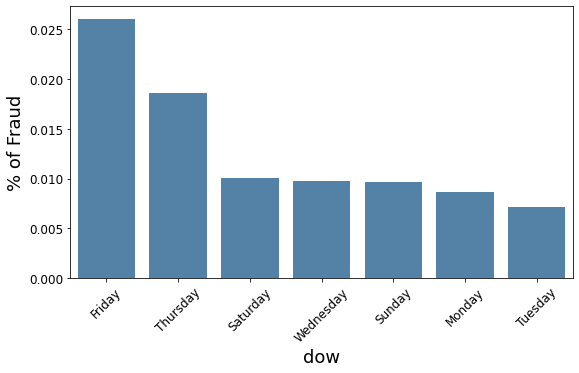

In [31]:
plt.figure(figsize = (9,5))
sns.barplot(x='dow', y='Fraud', data=plot, color='steelblue')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('dow', fontsize=18)
plt.ylabel('% of Fraud', fontsize=18)

### Benford's Law variables for Card number and Merchant

In [32]:
# ****A better, safer way would be to build these variables anew for each record, 
# ****using only the previous time data. 

bf = data.copy()
# remove Fedex transaction
bf['check_Fedex'] = bf['Merch description'].apply(lambda x:x[:5])
bf.drop(bf[bf['check_Fedex']=='FEDEX'].index, axis=0, inplace=True)
bf.drop('check_Fedex', axis=1, inplace=True)

# find the first digit of amount
bf['f_digit'] = bf['Amount'].apply(lambda x:int(str(x*100)[:1]))
bf['is_low'] = bf['f_digit'].apply(lambda x: 1 if x<3 else 0)

In [33]:
# group by 'Cardnum'
n_low = bf.groupby('Cardnum')['is_low'].sum()
n = bf.groupby('Cardnum')['f_digit'].count()
n_high = n - n_low
# if either n_low or n_high = 0, set them to 0
n_low = n_low.apply(lambda x: 1 if x==0 else x)
n_high = n_high.apply(lambda x: 1 if x==0 else x)
R = 1.096 * n_low / n_high
R_reverse = 1/R
r_df = pd.concat([R, R_reverse], axis=1).rename(columns={0:'R',1:'1/R'})
U = r_df[['R','1/R']].max(axis=1)
# smoothing
c=3
nmid=15
U_star = 1 + (U-1)/(1+np.exp(-(n-nmid)/c))
final['benford_card'] = final['Cardnum'].map(U_star)

In [34]:
# group by'Merchnum'
n_low = bf.groupby('Merchnum')['is_low'].sum()
n = bf.groupby('Merchnum')['f_digit'].count()
n_high = n - n_low
# if either n_low or n_high = 0, set them to 0
n_low = n_low.apply(lambda x: 1 if x==0 else x)
n_high = n_high.apply(lambda x: 1 if x==0 else x)
R = 1.096 * n_low / n_high
R_reverse = 1/R
r_df = pd.concat([R, R_reverse], axis=1).rename(columns={0:'R',1:'1/R'})
U = r_df[['R','1/R']].max(axis=1)
# smoothing
c=3
nmid=15
U_star = 1 + (U-1)/(1+np.exp(-(n-nmid)/c))
# fillin 1 for Fedex
U_star = U_star.append(pd.Series([1], index=['5509006296254']))
final['benford_merch'] = final['Merchnum'].map(U_star)

In [ ]:
final[[]]

In [48]:
Uc = final.sort_values(['benford_card'], ascending=False)[['Cardnum','benford_card']].drop_duplicates()
Uc = Uc.reset_index(drop=True)[:20]

In [49]:
Uc.to_csv('benford_car.csv')

In [52]:
Um = final.sort_values(['benford_merch'], ascending=False)[['Merchnum','benford_merch']].drop_duplicates()
Um = Um.reset_index(drop=True)[:20]

In [53]:
Um.to_csv('benford_merch.csv')

In [35]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,card_state_count_1_by_7,card_state_amount_1_by_7,card_state_count_1_by_14,card_state_amount_1_by_14,card_state_count_1_by_30,card_state_amount_1_by_30,dow,dow_risk,benford_card,benford_merch
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,7.0,3.601697,14.0,5.052264,30.0,6.595622,Friday,0.025994,2.178008,1.000000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,7.0,4.103679,14.0,5.990636,30.0,6.818594,Friday,0.025994,1.604857,1.000894
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,7.0,4.097748,14.0,6.260969,30.0,8.987599,Friday,0.025994,2.368143,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,7.0,2.050805,14.0,2.324949,30.0,2.867464,Friday,0.025994,1.044105,1.000000
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,7.0,3.601697,14.0,5.052264,30.0,6.595622,Friday,0.025994,2.178008,1.000000


## Filter

In [61]:
df = final.copy()

In [62]:
#remove the first 2 weeks and the last 2 months
df = df[(df['Date']>'2010-01-14') & (df['Date']<'2010-11-01')]

In [63]:
#drop unnecessary columns, keep 'Fraud' & 'Amount'
drop_cols = ['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description','Merch state', 
             'Merch zip', 'Transtype','Amount','card_merchnum', 'card_zip', 'card_state','dow']

In [64]:
df.drop(drop_cols, axis=1, inplace=True)

In [65]:
# Create KSFDR dataframe
#each observation is a column in data
KSFDR = pd.DataFrame()

### Univariate KS

In [66]:
goods=df[df['Fraud']==0]
bads=df[df['Fraud']==1]

In [67]:
i = 0
for column in goods.columns:
    KSFDR.loc[i,'variable'] = column
    KSFDR.loc[i,'ks'] = sps.ks_2samp(goods[column],bads[column])[0]
    i = i+1
KSFDR

,variable,ks
0,Fraud,1.000000
1,Cardnum_day_since,0.291223
2,Cardnum_count_0,0.339447
3,ave_amount_Cardnum_count_0,0.464299
4,max_amount_Cardnum_count_0,0.453079
...,...,...
354,card_state_count_1_by_30,0.185064
355,card_state_amount_1_by_30,0.267133
356,dow_risk,0.134586
357,benford_card,0.439728


### Univariate FDR at 3%

In [68]:
listvars = goods.columns
listvars=listvars.drop('Fraud')

In [69]:
numbads = len(df[df['Fraud']==1])

j = 1
topRows = int(round(len(final)*0.03))
for column in listvars:
    temp = df[[column,'Fraud']].copy()
    temp0 = temp.sort_values(column,ascending=False)
    temp1 = temp0.head(topRows)
    temp2 = temp0.tail(topRows)
    needed1 = temp1.loc[:,'Fraud']
    needed2 = temp2.loc[:,'Fraud']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[j, 'FDR'] = FDRate
    j = j + 1

In [70]:
KSFDR.loc[0,'FDR']=1
KSFDR

,variable,ks,FDR
0,Fraud,1.000000,1.000000
1,Cardnum_day_since,0.291223,0.024194
2,Cardnum_count_0,0.339447,0.209677
3,ave_amount_Cardnum_count_0,0.464299,0.384793
4,max_amount_Cardnum_count_0,0.453079,0.203917
...,...,...,...
354,card_state_count_1_by_30,0.185064,0.082949
355,card_state_amount_1_by_30,0.267133,0.087558
356,dow_risk,0.134586,0.088710
357,benford_card,0.439728,0.258065


In [71]:
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)

In [72]:
KSFDR

,variable,ks,FDR,rank_ks,rank_FDR,average_rank
0,Fraud,1.000000,1.000000,359.0,359.0,359.00
101,ave_amount_card_zip_count_1,0.620377,0.390553,354.0,326.5,340.25
111,ave_amount_card_zip_count_7,0.611480,0.394009,348.0,328.0,338.00
106,ave_amount_card_zip_count_3,0.614635,0.388249,350.0,325.0,337.50
132,ave_amount_card_state_count_1,0.599873,0.471198,336.0,339.0,337.50
...,...,...,...,...,...,...
297,Merchnum_amount_0_by_14,0.153507,0.010369,61.0,24.0,42.50
252,act/mean_amount_card_state_count_0,0.105880,0.021889,27.5,54.5,41.00
254,act/sum_amount_card_state_count_0,0.105880,0.021889,27.5,54.5,41.00
299,Merchnum_amount_0_by_30,0.148993,0.010369,57.0,24.0,40.50


In [78]:
top80list = KSFDR.iloc[1:81]['variable'].values.tolist()

In [79]:
top80list

['ave_amount_card_zip_count_1',
 'ave_amount_card_zip_count_7',
 'ave_amount_card_zip_count_3',
 'ave_amount_card_state_count_1',
 'ave_amount_card_state_count_0',
 'median_amount_card_state_count_3',
 'median_amount_card_state_count_1',
 'max_amount_card_merchnum_count_7',
 'max_amount_card_merchnum_count_0',
 'max_amount_card_merchnum_count_1',
 'max_amount_card_merchnum_count_3',
 'max_amount_card_merchnum_count_30',
 'max_amount_card_merchnum_count_14',
 'ave_amount_card_state_count_3',
 'max_amount_card_zip_count_0',
 'max_amount_card_zip_count_1',
 'max_amount_card_zip_count_30',
 'max_amount_card_zip_count_3',
 'max_amount_card_zip_count_7',
 'ave_amount_card_zip_count_0',
 'max_amount_card_zip_count_14',
 'ave_amount_card_state_count_30',
 'ave_amount_card_state_count_14',
 'ave_amount_card_state_count_7',
 'ave_amount_card_merchnum_count_1',
 'ave_amount_card_zip_count_30',
 'ave_amount_card_merchnum_count_3',
 'median_amount_card_zip_count_0',
 'median_amount_card_state_count

In [81]:
top80=df[top80list]

In [82]:
top80

,ave_amount_card_zip_count_1,ave_amount_card_zip_count_7,ave_amount_card_zip_count_3,ave_amount_card_state_count_1,ave_amount_card_state_count_0,median_amount_card_state_count_3,median_amount_card_state_count_1,max_amount_card_merchnum_count_7,max_amount_card_merchnum_count_0,max_amount_card_merchnum_count_1,...,sum_amount_card_state_count_1,ave_amount_Cardnum_count_30,sum_amount_card_state_count_3,sum_amount_card_state_count_0,act/median_amount_Merchnum_count_30,sum_amount_card_state_count_7,sum_amount_card_zip_count_30,sum_amount_card_state_count_14,sum_amount_Cardnum_count_1,act/median_amount_Merchnum_count_14
3344,388.846818,403.836857,351.452308,401.771071,401.771071,234.88,254.465,1602.81,1602.81,1602.81,...,11249.59,481.111228,12521.12,11249.59,1.678512,17912.65,23550.930000,22849.72,577398.84,1.678512
3345,5.158783,5.286674,5.258034,5.158783,4.997035,3.80,3.800,41.25,41.25,41.25,...,82298.07,7.469275,142066.83,59909.45,1.168449,280907.43,861019.430001,495569.22,109586.82,1.168449
3346,303.658805,312.223341,311.070961,326.337446,336.228780,168.73,171.390,718.71,718.71,718.71,...,166105.76,473.955062,239008.15,112972.87,1.635472,387335.21,362346.110000,665880.68,2639416.98,1.690266
3347,5.158783,5.286674,5.258034,5.158783,4.997035,3.80,3.800,41.25,41.25,41.25,...,82298.07,7.469275,142066.83,59909.45,0.967914,280907.43,861019.430001,495569.22,109586.82,0.967914
3348,179.658333,194.044286,194.044286,143.050000,143.050000,150.59,126.095,280.36,280.36,280.36,...,1144.40,257.354815,1424.76,1144.40,0.135678,1424.76,1740.270000,1526.36,5080.26,0.109093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84294,181.385000,220.846667,220.846667,181.385000,181.385000,299.77,181.385,299.77,299.77,299.77,...,362.77,103.239578,662.54,362.77,2.611237,662.54,662.540000,662.54,31250.29,2.656358
84295,251.855556,228.526000,228.526000,233.324000,233.324000,179.98,179.980,691.57,691.57,691.57,...,2333.24,220.282664,2546.77,2333.24,4.378701,2546.77,4304.630000,3069.79,17104.87,4.427056
84296,235.000000,235.000000,235.000000,235.000000,235.000000,235.00,235.000,235.00,235.00,235.00,...,235.00,590.978208,235.00,235.00,2.022897,235.00,235.000000,235.00,19163.66,2.022897
84297,600.000000,600.000000,600.000000,312.500000,312.500000,312.50,312.500,600.00,600.00,600.00,...,625.00,287.115510,625.00,625.00,1.000000,625.00,600.000000,625.00,9251.07,1.000000


# Wrapper

In [83]:
Y = df['Fraud']

In [85]:
# definde fdr as the measure of goodenss for the wrapper
def fdr(classifier, x, y, cutoff=0.03):
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) != 1:
        y_prob = y_prob[:, -1]
    num_fraud = len(y[y==1])
    
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    
    cutoff_bin = sorted_prob[0:int(len(y)*cutoff), 1:]
    
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud

In [86]:
%%time 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = DecisionTreeClassifier(criterion='gini',max_depth=10)
sfs=SFS(model, k_features=79,forward=True,verbose=2,scoring=fdr,cv=0)
#sfs=SFS(model, k_features=79,forward=True,verbose=2,scoring='accuracy',cv=0)
sfs.fit(top80,Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   53.0s finished

[2021-05-07 20:51:31] Features: 1/79 -- score: 0.8870967741935484[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   43.4s finished

[2021-05-07 20:52:14] Features: 2/79 -- score: 0.9389400921658986[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   49.2s finished

[2021-05-07 20:53:04] Features: 3/79 -- score: 0.966589861751152[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  2.3min finished

[2021-05-07 21:40:32] Features: 29/79 -- score: 0.9700460829493087[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  2.4min finished

[2021-05-07 21:42:56] Features: 30/79 -- score: 0.9654377880184332[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.4min finished

[2021-05-07 21:45:22] Features: 31/79 -- score: 0.9631336405529954[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done

Wall time: 57min 31s



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

SequentialFeatureSelector(cv=0, estimator=DecisionTreeClassifier(max_depth=10),
                          k_features=79,
                          scoring=<function fdr at 0x0000024C22F9B550>,
                          verbose=2)

In [87]:
sfs.k_feature_names_

('ave_amount_card_zip_count_1',
 'ave_amount_card_zip_count_7',
 'ave_amount_card_zip_count_3',
 'ave_amount_card_merchnum_count_1',
 'ave_amount_card_zip_count_30',
 'ave_amount_card_merchnum_count_3',
 'median_amount_card_zip_count_0',
 'median_amount_card_zip_count_3',
 'median_amount_card_state_count_7',
 'ave_amount_card_zip_count_14',
 'median_amount_card_zip_count_1',
 'ave_amount_card_merchnum_count_7',
 'median_amount_card_zip_count_14',
 'median_amount_card_zip_count_7',
 'median_amount_card_merchnum_count_0',
 'ave_amount_card_merchnum_count_30',
 'ave_amount_card_merchnum_count_14',
 'median_amount_card_merchnum_count_1',
 'median_amount_card_state_count_14',
 'median_amount_card_merchnum_count_3',
 'median_amount_card_zip_count_30',
 'ave_amount_Cardnum_count_1',
 'median_amount_card_merchnum_count_14',
 'median_amount_card_merchnum_count_30',
 'median_amount_card_state_count_30',
 'ave_amount_Cardnum_count_3',
 'ave_amount_Cardnum_count_7',
 'median_amount_card_merchnum_c

In [88]:
features=pd.DataFrame.from_dict(sfs.get_metric_dict()).T

C:\Users\Lin Liu\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lin Liu\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [100]:
top30list = list(features.loc[30]['feature_names'])

In [101]:
top30list

['ave_amount_card_zip_count_1',
 'ave_amount_card_zip_count_7',
 'ave_amount_card_zip_count_3',
 'ave_amount_card_zip_count_30',
 'ave_amount_card_merchnum_count_3',
 'median_amount_card_zip_count_0',
 'median_amount_card_zip_count_3',
 'median_amount_card_state_count_7',
 'ave_amount_card_zip_count_14',
 'median_amount_card_zip_count_1',
 'ave_amount_card_merchnum_count_7',
 'median_amount_card_zip_count_14',
 'median_amount_card_zip_count_7',
 'median_amount_card_merchnum_count_0',
 'ave_amount_card_merchnum_count_30',
 'ave_amount_card_merchnum_count_14',
 'median_amount_card_merchnum_count_1',
 'median_amount_card_state_count_14',
 'median_amount_card_merchnum_count_3',
 'median_amount_card_zip_count_30',
 'ave_amount_Cardnum_count_1',
 'median_amount_card_merchnum_count_14',
 'median_amount_card_merchnum_count_30',
 'median_amount_card_state_count_30',
 'ave_amount_Cardnum_count_3',
 'ave_amount_Cardnum_count_7',
 'median_amount_card_merchnum_count_7',
 'ave_amount_Cardnum_count_0

In [ ]:
# sort the top 30 by their importance
result = features.loc[0:30]['feature_names']
sorted30 = []
for l in result:
    for i in l:
        if i not in sorted30:
            sorted30.append(i)

In [129]:
sorted30

['ave_amount_card_merchnum_count_14',
 'sum_amount_Cardnum_count_1',
 'median_amount_card_merchnum_count_1',
 'ave_amount_card_merchnum_count_30',
 'ave_amount_card_merchnum_count_7',
 'median_amount_card_merchnum_count_3',
 'median_amount_card_merchnum_count_0',
 'median_amount_card_state_count_7',
 'median_amount_card_state_count_14',
 'median_amount_card_zip_count_30',
 'ave_amount_card_zip_count_7',
 'median_amount_card_zip_count_7',
 'median_amount_card_zip_count_14',
 'median_amount_card_merchnum_count_30',
 'median_amount_card_merchnum_count_7',
 'median_amount_card_state_count_30',
 'ave_amount_card_zip_count_1',
 'median_amount_card_merchnum_count_14',
 'ave_amount_card_zip_count_3',
 'ave_amount_card_merchnum_count_3',
 'ave_amount_card_zip_count_14',
 'ave_amount_card_zip_count_30',
 'median_amount_card_zip_count_3',
 'median_amount_card_zip_count_0',
 'median_amount_card_zip_count_1',
 'ave_amount_Cardnum_count_0',
 'ave_amount_Cardnum_count_3',
 'ave_amount_Cardnum_count_1

In [126]:
top30 = final[['Recnum','Date','Fraud']+sorted30]

In [127]:
top30.head()

,Recnum,Date,Fraud,ave_amount_card_merchnum_count_14,sum_amount_Cardnum_count_1,median_amount_card_merchnum_count_1,ave_amount_card_merchnum_count_30,ave_amount_card_merchnum_count_7,median_amount_card_merchnum_count_3,median_amount_card_merchnum_count_0,...,ave_amount_card_zip_count_14,ave_amount_card_zip_count_30,median_amount_card_zip_count_3,median_amount_card_zip_count_0,median_amount_card_zip_count_1,ave_amount_Cardnum_count_0,ave_amount_Cardnum_count_3,ave_amount_Cardnum_count_1,ave_amount_Cardnum_count_7,ave_amount_Cardnum_count_30
0,1,2010-01-01,0,3.662766,38758.43,3.62,3.666297,3.655909,3.62,3.62,...,7.076372,7.666234,3.62,3.62,3.62,16.797628,30.630963,24.989317,30.223873,33.789793
1,2,2010-01-01,0,31.420000,818645.77,31.42,31.420000,31.420000,31.42,31.42,...,94.590000,94.590000,51.71,51.71,51.71,1284.967703,969.576929,1127.611253,775.627244,538.009019
2,3,2010-01-01,0,278.148571,523167.62,258.09,304.816667,294.758333,258.09,258.09,...,264.874444,289.107273,229.95,229.95,229.95,793.786176,850.361427,838.409647,853.536117,780.180688
3,4,2010-01-01,0,4.782699,109586.82,3.85,4.721352,4.837090,3.80,3.80,...,5.260876,5.281226,3.80,3.80,3.80,5.444532,6.599404,6.799033,7.181371,7.469275
4,5,2010-01-01,0,3.662766,38758.43,3.62,3.666297,3.655909,3.62,3.62,...,7.076372,7.666234,3.62,3.62,3.62,16.797628,30.630963,24.989317,30.223873,33.789793


C:\Users\Lin Liu\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lin Liu\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


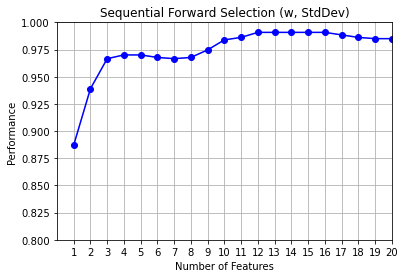

In [108]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(),
                kind = 'std_dev')
plt.ylim([.8,1])
plt.xlim(0,20)
plt.title('Sequential Forward Selection (w, StdDev)')
plt.grid()
plt.show()

In [128]:
top30.to_csv('top30.csv')